In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

col_names = ['satisfaction_level', 'last_evaluation', 'number_project',
             'average_monthly_hours', 'time_spend_company', 'work_accident',
             'left', 'promotion_last_5years', 'department', 'salary']

hr = pd.read_csv("../HR_comma_sep.csv", header = 0, names = col_names)
hr.head(5)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [2]:
# hr_x = hr.drop(["left", "department", "salary"], axis = 1)

hr_x = hr.drop(["left", "department"], axis = 1)

hr_x.loc[hr_x["salary"] == "low", "salary"] = 1
hr_x.loc[hr_x["salary"] == "medium", "salary"] = 2
hr_x.loc[hr_x["salary"] == "high", "salary"] = 3
# can't use quantitative variables in KNN
# utilising salary did not increase the overall testing accuracy (why is this?...)

hr_y = hr["left"]

In [3]:
hr_x.shape

(14999, 8)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(hr_x, hr_y, 
                                                    stratify = hr_y, random_state=0,
                                                   test_size = 0.4)

x_label = np.arange(1, 21)
acc_train = []
acc_test = []

for i in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    acc_train.append(knn.score(X_train, y_train))
    acc_test.append(knn.score(X_test, y_test))

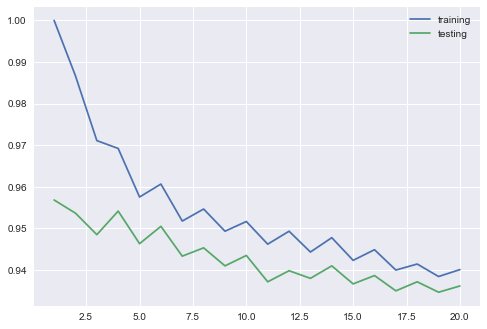

In [5]:
# sns.jointplot(x = x_label, y = acc_train)
# sns.jointplot(x = x_label, y = acc_test)
# sns.plt.show()

plt.plot(x_label, acc_train, label = "training")
plt.plot(x_label, acc_test, label = "testing")
plt.legend()
plt.show()

#### great! Model for KNN from k = 1, ... , 20 with roughly 95% accuracy. We're done right?

# It is not so simple unfortunately

First of all you probably want to look at the __null accuracy__:

In [250]:
round(len(hr[hr["left"] == 0])/len(hr), 3)
# Generalise the code: hr.left.value_counts()[0]/len(hr)

0.762

### so 76% is the benchmark for any model... so 95% for a straight-off is not too bad. 

### We also want to now the types of errors that the model makes. 

But for now, we need to finetune the model a little bit. 95% is good but I'm sure we can make that a little bit better

This algorithm of KNN is based on Euclidean distance. The numerical values from average monthly hours will therefore carry much of the weight as they are the largest, the values of the features should be normalised. 

The Manhattan formula focuses on sum of absolute deviation

With categorical variables, utilise Hamming (which simply compares equality between the features in a single attribute).

# Preprocess the Data

In [251]:
# normalise data

from sklearn import preprocessing


## Normalising columns separately

How does the axis change the normalisation?

axis = 1: normalises across each sample
axis = 0: normalises across each individual feature. 

In [126]:
hr_sat = preprocessing.normalize(hr_x["satisfaction_level"], axis = 1)
hr_hours = preprocessing.normalize(hr_x["average_monthly_hours"], axis = 1)

/Users/Jerry/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/Jerry/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/Jerry/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [127]:
print(max(hr["average_monthly_hours"]))
print(min(hr["average_monthly_hours"]))

310
96


In [128]:
print(max(hr["satisfaction_level"]))
print(min(hr["satisfaction_level"]))

1.0
0.09


In [132]:
print(max(hr_hours[0]))
print(min(hr_hours[0]))
print("---")
print(max(hr_sat[0]))
print(min(hr_sat[0]))

0.0122186728244
0.0037838470682
---
0.0123464009808
0.00111117608827


## Normalising the dataframe as a whole

##### Why are the resulting normalised values differernt? 

In [183]:
hr_norm = preprocessing.normalize(hr_x["average_monthly_hours"], axis = 1, norm = "max")

/Users/Jerry/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/Jerry/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [206]:
hr_x.ix[:10, "satisfaction_level"]

0     0.38
1     0.80
2     0.11
3     0.72
4     0.37
5     0.41
6     0.10
7     0.92
8     0.89
9     0.42
10    0.45
Name: satisfaction_level, dtype: float64

In [208]:
count = 0
for index in hr_norm:
    print(index)
    count += 1
    if count == 10:
        break

[ 0.00469163  0.00587768  0.00408487  0.00618817  0.00646204  0.          0.
  0.00475474]
[ 0.00987712  0.00953736  0.01021217  0.01032675  0.01292407  0.          0.
  0.00950948]
[ 0.0013581   0.00975916  0.01429703  0.0107209   0.00861605  0.          0.
  0.00950948]
[ 0.00888941  0.00964826  0.01021217  0.00878956  0.01077006  0.          0.
  0.00475474]
[ 0.00456817  0.00576678  0.00408487  0.006267    0.00646204  0.          0.
  0.00475474]
[ 0.00506202  0.00554498  0.00408487  0.00603051  0.00646204  0.          0.
  0.00475474]
[ 0.00123464  0.00853926  0.0122546   0.00973552  0.00861605  0.          0.
  0.00475474]
[ 0.01135869  0.00942646  0.01021217  0.0102085   0.01077006  0.          0.
  0.00475474]
[ 0.0109883   0.01108995  0.01021217  0.00882898  0.01077006  0.          0.
  0.00475474]
[ 0.00518549  0.00587768  0.00408487  0.00559694  0.00646204  0.          0.
  0.00475474]


In [197]:
hr_norm = preprocessing.normalize(hr_x, axis = 0)

In [198]:
count = 0
for index in hr_norm:
    print(index)
    count += 1
    if count == 10:
        break

[ 0.00469163  0.00587768  0.00408487  0.00618817  0.00646204  0.          0.
  0.00475474]
[ 0.00987712  0.00953736  0.01021217  0.01032675  0.01292407  0.          0.
  0.00950948]
[ 0.0013581   0.00975916  0.01429703  0.0107209   0.00861605  0.          0.
  0.00950948]
[ 0.00888941  0.00964826  0.01021217  0.00878956  0.01077006  0.          0.
  0.00475474]
[ 0.00456817  0.00576678  0.00408487  0.006267    0.00646204  0.          0.
  0.00475474]
[ 0.00506202  0.00554498  0.00408487  0.00603051  0.00646204  0.          0.
  0.00475474]
[ 0.00123464  0.00853926  0.0122546   0.00973552  0.00861605  0.          0.
  0.00475474]
[ 0.01135869  0.00942646  0.01021217  0.0102085   0.01077006  0.          0.
  0.00475474]
[ 0.0109883   0.01108995  0.01021217  0.00882898  0.01077006  0.          0.
  0.00475474]
[ 0.00518549  0.00587768  0.00408487  0.00559694  0.00646204  0.          0.
  0.00475474]


here the entire database has been standardised to each individual predictor

Let's see if we can get an improvement to the model with this.

In [200]:
X_train, X_test, y_train, y_test = train_test_split(hr_norm, hr_y, 
                                                    stratify = hr_y, random_state=0,
                                                   test_size = 0.4)

x_label = np.arange(1, 21)
acc_train_norm = []
acc_test_norm = []

for i in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    
    acc_train_norm.append(knn.score(X_train, y_train))
    acc_test_norm.append(knn.score(X_test, y_test))

### Compare the accuracy before and after normalisation

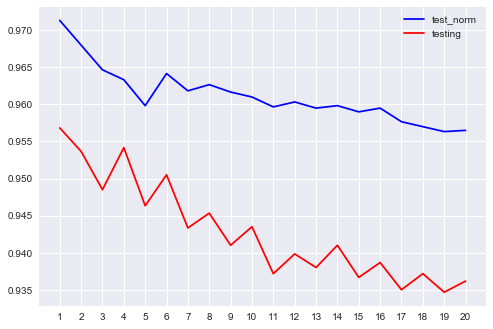

In [209]:
plt.plot(x_label, acc_test_norm, 
         label = "test_norm", color = "b")
plt.plot(x_label, acc_test, 
         label = "testing", color = "r")

plt.xticks(x_label)
plt.legend()
plt.show()

In [210]:
print("For k = 3, the training and testing accuracy are:")

print("with no normalisation: {0}% & {1}% respectively".format(round(acc_train[2], 3), 
                                                               round(acc_test[2], 3)))

print("with normalisation: {0}% & {1}% respectively".format(round(acc_train_norm[2], 3), 
                                                            round(acc_test_norm[2], 3)))

For k = 3, the training and testing accuracy are:
with no normalisation: 0.971% & 0.948% respectively
with normalisation: 0.98% & 0.965% respectively


## K-fold Cross-Validation

As of now I'm not sure about one-hot encoding's result. So I will instead attempt a k-fold cross validation on the normalised dataset

In [217]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors = 3)
hr_norm_kfold = cross_val_score(knn, hr_norm, hr_y, cv=10, scoring = "accuracy")

In [218]:
print(hr_norm_kfold)
hr_norm_kfold.mean()

[ 0.97601599  0.98        0.95333333  0.95333333  0.94733333  0.964
  0.98266667  0.972       0.99266177  0.98465644]


0.97060008681485344

The average is similar to the 96.5% acheived above

In [220]:
x_label = np.arange(1, 21)
acc_kfold_avgs = []

for i in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors = i)
    acc_kfold_avgs.append(cross_val_score(knn, hr_norm, hr_y, cv = 10, scoring = "accuracy").mean())

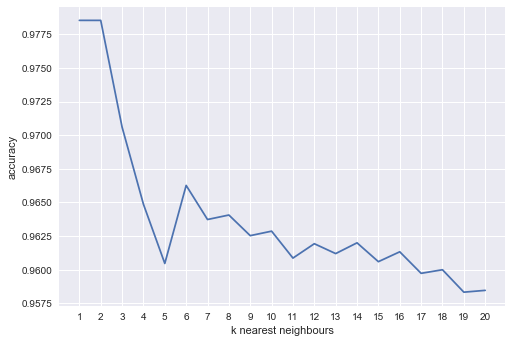

In [223]:
plt.plot(x_label, acc_kfold_avgs)
plt.xticks(x_label)
plt.xlabel("k nearest neighbours")
plt.ylabel("accuracy")
plt.show()

__NEXT STEPS__

1) Normalise data, decide whether or not to use one hot encoding

2) Try k-fold cross validation using GridSearch

3) Try running a logistic regression for the problem. <br>  

    i) Setting thresholds for logistic regression

4) Look at Confusion Matrix for Classifier



## One-hot encoding of Quantitative Variables

In [77]:
hr_onehot = pd.get_dummies(hr)
print(hr_onehot.shape)
print(hr_onehot.columns)

(14999, 21)
Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department_IT', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng', 'department_sales',
       'department_support', 'department_technical', 'salary_high',
       'salary_low', 'salary_medium'],
      dtype='object')


On top of this, we want to normalise the quantitative variables as well

In [76]:
hr_norm

array([[ 0.00241958,  0.00337467,  0.01273461, ...,  0.        ,
         0.00636731,  0.        ],
       [ 0.00305198,  0.00328088,  0.01907489, ...,  0.        ,
         0.        ,  0.00381498],
       [ 0.00040422,  0.00323379,  0.02572334, ...,  0.        ,
         0.        ,  0.00367476],
       ..., 
       [ 0.00258637,  0.00370481,  0.0139804 , ...,  0.        ,
         0.0069902 ,  0.        ],
       [ 0.00039272,  0.00342735,  0.02142093, ...,  0.        ,
         0.00357016,  0.        ],
       [ 0.002341  ,  0.00329006,  0.01265407, ...,  0.        ,
         0.00632704,  0.        ]])

In [56]:
hr_norm = preprocessing.normalize(hr_onehot, axis = 1)

In [79]:
hr_norm_zero = preprocessing.normalize(hr_onehot, axis = 0)
hr_norm_zero

array([[ 0.00469163,  0.00587768,  0.00408487, ...,  0.        ,
         0.01169131,  0.        ],
       [ 0.00987712,  0.00953736,  0.01021217, ...,  0.        ,
         0.        ,  0.01245532],
       [ 0.0013581 ,  0.00975916,  0.01429703, ...,  0.        ,
         0.        ,  0.01245532],
       ..., 
       [ 0.00456817,  0.00587768,  0.00408487, ...,  0.        ,
         0.01169131,  0.        ],
       [ 0.0013581 ,  0.01064635,  0.0122546 , ...,  0.        ,
         0.01169131,  0.        ],
       [ 0.00456817,  0.00576678,  0.00408487, ...,  0.        ,
         0.01169131,  0.        ]])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(hr_norm, hr_y, 
                                                    stratify = hr_y, random_state=0,
                                                   test_size = 0.4)

x_label = np.arange(1, 21)
acc_train_norm_onehot = []
acc_test_norm_onehot = []


for i in range(1, 5):
    knn.fit(X_train, y_train)
    
    acc_train_norm_onehot.append(knn.score(X_train, y_train))
    acc_test_norm_onehot.append(knn.score(X_test, y_test))

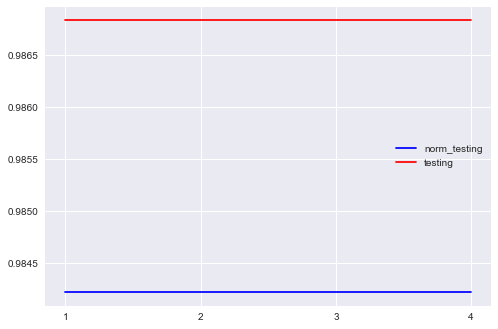

In [75]:
plt.plot([1,2,3,4], acc_train_norm_onehot, 
         label = "norm_testing", color = "b")
plt.plot([1,2,3,4], acc_test_norm_onehot, 
         label = "testing", color = "r")

plt.xticks([1, 2, 3, 4])
plt.legend()
plt.show()

## Logistic Regression for the Problem

In [252]:
from sklearn.neighbors import regression